In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import time
import random
from scipy import stats
from scipy.stats import mode
import seaborn as sns
import warnings
from collections import defaultdict
warnings.filterwarnings("ignore")

### Functions

In [7]:
def beta_binomial_p(a_mutated_branches, b_mutated_branches, 
           a_unmutated_branches, b_unmutated_branches, PSEUDOCOUNT_VALUE = 1, verbose=False):
    
    
    """
    Computes p-value of the inferred mu from the non-mutated branches versus the posterior
    distribution of mutated + unmutated branches
    
    """
   #pseudocounting
    if a_mutated_branches ==0:
        return np.nan
    if a_mutated_branches ==0:
        b_mutated_branches += PSEUDOCOUNT_VALUE
    if a_unmutated_branches ==0:
        a_unmutated_branches += PSEUDOCOUNT_VALUE
    if b_unmutated_branches ==0:
        b_unmutated_branches += PSEUDOCOUNT_VALUE

    beta_posterior = stats.beta(a=a_unmutated_branches + a_mutated_branches, b=b_unmutated_branches + b_mutated_branches)
    
    prior_mean = a_unmutated_branches/(a_unmutated_branches+b_unmutated_branches)
    
    pval = beta_posterior.cdf(prior_mean)
    if verbose:
        print(f"a_unmutated_branches: {a_unmutated_branches}")
        print(f"b_unmutated_branches: {b_unmutated_branches}")
        print(f"a_mutated_branches: {a_mutated_branches}")
        print(f"b_mutated_branches: {b_mutated_branches}")
        print(f"pvalue:{pval}")
    return pval

        df['pval_betabin_i_on_j'] = df.apply(lambda row: beta_binomial_p (
            row['n_muts_i_on_branch_j'] + row['n_muts_same_branch'], 
            row['n_branch_with_j_no_i'] - row['n_muts_i_on_branch_j'], 
            row['n_mutations_i_on_unmutated'],
            row["n_unmutated_branches_i"] - row['n_mutations_i_on_unmutated'], verbose=verbose
        ), axis = 1) 

def hypergeometric_p(M, N, n, k, verbose=False):
    
    """
    Computes the p-value of drawing k mutations on mutated branches out of n total mutations
    
    M: total population
    N: number of successes in population (branches with mutation j)
    n: number of draws
    k: number of successful draws
    """

    
    distr = stats.hypergeom(M, n, N)
    pval = 1 - distr.cdf(k - 0.0000001)
    
    
    if verbose:
        print(f"total branches:{M}\ntotal successes:{N}\ntotal draws:{n}\nNumber of successful draws:{k}")
        print(f"pvalue:{pval}")
        
    return pval


def beta_p(a_mutated_branches, b_mutated_branches, 
           a_unmutated_branches, b_unmutated_branches, PSEUDOCOUNT_VALUE = 1, verbose=False):
    
    """
    Computes p-value of the inferred mu from the non-mutated branches versus the posterior
    distribution of mutated + non-mutated branches
    
    """
    #pseudocounting
    
    if a_mutated_branches ==0:
        return np.nan
    if a_mutated_branches ==0:
        b_mutated_branches += PSEUDOCOUNT_VALUE
    if a_unmutated_branches ==0:
        a_unmutated_branches += PSEUDOCOUNT_VALUE
    if b_unmutated_branches ==0:
        b_unmutated_branches += PSEUDOCOUNT_VALUE

    beta_posterior = stats.beta(a=a_mutated_branches, b=b_mutated_branches)
    
    prior_mean = a_unmutated_branches/(a_unmutated_branches+b_unmutated_branches)
    
    pval = beta_posterior.cdf(prior_mean)
    if verbose:
        print(f"a_unmutated_branches: {a_unmutated_branches}")
        print(f"b_unmutated_branches: {b_unmutated_branches}")
        print(f"a_mutated_branches: {a_mutated_branches}")
        print(f"b_mutated_branches: {b_mutated_branches}")
        print(f"pvalue:{pval}")
        
    return pval

def apply_testing(df, total_branches=None, verbose=False, run_hypergeometric=False, run_betabin=False):
    if total_branches is None:
        total_branches = len(np.load("00.mutation_data_by_lineage/00.combined_data/all_branches.npy"))
    
    df["total_branches_applicable"] = total_branches - df.n_branch_i_and_j

    df["n_unmutated_branches_i"] = df.total_branches_applicable - df.n_branch_with_i_no_j
    df["n_unmutated_branches_j"] = df.total_branches_applicable - df.n_branch_with_j_no_i
    df["n_mutations_i_on_unmutated"] = df.n_mutations_i -df.n_muts_i_on_branch_j
    df["n_mutations_j_on_unmutated"] = df.n_mutations_j  -df.n_muts_j_on_branch_i
    
    if run_hypergeometric:
        print('running hypergeometric i on j')
        df['pval_hypergeo_i_on_j'] = df.apply(lambda row: hypergeometric_p (
            row['total_branches_applicable'] - row["n_branch_with_i_no_j"], 
            row['n_branch_with_j_no_i'], 
            row['n_mutations_i'],
            row['n_muts_i_on_branch_j'] + row['n_muts_same_branch'], verbose=verbose
        ), axis = 1) 
        print('running hypergeometric j on i')
        df['pval_hypergeo_j_on_i'] = df.apply(lambda row: hypergeometric_p (
            row['total_branches_applicable'] - row["n_branch_with_j_no_i"], 
            row['n_branch_with_i_no_j'], 
            row['n_mutations_j'],
            row['n_muts_j_on_branch_i'] + row['n_muts_same_branch'], verbose=verbose
        ), axis = 1) 
    if run_betabin:
        print('running beta-binomial i on j')
        df['pval_betabin_i_on_j'] = df.apply(lambda row: beta_binomial_p (
            row['n_muts_i_on_branch_j'] + row['n_muts_same_branch'], 
            row['n_branch_with_j_no_i'] - row['n_muts_i_on_branch_j'], 
            row['n_mutations_i_on_unmutated'],
            row["n_unmutated_branches_i"] - row['n_mutations_i_on_unmutated'], verbose=verbose
        ), axis = 1) 
        print('running beta-binomial j on i')
        df['pval_betabin_j_on_i'] = df.apply(lambda row: beta_binomial_p (
            row['n_muts_j_on_branch_i'] + row['n_muts_same_branch'], 
            row['n_branch_with_i_no_j'] - row['n_muts_j_on_branch_i'], 
            row['n_mutations_j_on_unmutated'],
            row["n_unmutated_branches_j"] - row['n_mutations_j_on_unmutated'], verbose=verbose
        ), axis = 1) 
    print('running beta i on j')
    df['pval_beta_i_on_j'] = df.apply(lambda row: beta_p (
        row['n_muts_i_on_branch_j'] + row['n_muts_same_branch'], 
        row['n_branch_with_j_no_i'] - row['n_muts_i_on_branch_j'], 
        row['n_mutations_i_on_unmutated'],
        row["n_unmutated_branches_i"] - row['n_mutations_i_on_unmutated'] - row['n_branch_with_j_no_i'], verbose=verbose
    ), axis = 1) 
    print('running beta j on i')
    df['pval_beta_j_on_i'] = df.apply(lambda row: beta_p (
        row['n_muts_j_on_branch_i'] + row['n_muts_same_branch'], 
        row['n_branch_with_i_no_j'] - row['n_muts_j_on_branch_i'], 
        row['n_mutations_j_on_unmutated'],
        row["n_unmutated_branches_j"] - row['n_mutations_j_on_unmutated'] - row['n_branch_with_i_no_j'], verbose=verbose
    ), axis = 1) 
    
    return df

### Compute FDR control using Benjamini-Hochberg

def benjamini_hochberg(df, pval_column, threshold = 0.001):
    df = df.sort_values(pval_column)
    M = len(df)
    df["_rank"] = [x for x in range(len(df))]
    df["BH_critical_value"] = [threshold * x/M for x in df._rank]
    df[pval_column+"_BH_sig"] = [p<=x for p,x in zip(df[pval_column], df.BH_critical_value)]
    df = df.drop(["_rank"], axis=1)
    return df
def holms(df, pval_column, threshold = 0.001):
    df = df.sort_values(pval_column)
    output = multipletests(df[pval_column], threshold, method="hs")
    df[pval_column+"_BH_sig"] = output[0]
    return df


def unravel_ij(df):
    """
    
    """
    
    reversal_df = deepcopy(df)
    reversal_df = reversal_df.rename({
        "position_i":"position_j",
#         "gene_name_i":"gene_name_j",
        "position_j":"position_i",
#         "gene_name_j":"gene_name_i",
        "n_mutations_i":"n_mutations_j",
        "n_mutations_j":"n_mutations_i",
        "n_branches_with_i":"n_branches_with_j",
        "n_branches_with_j":"n_branches_with_i",
        "n_muts_i_on_branch_j":"n_muts_j_on_branch_i",
        "n_muts_j_on_branch_i":"n_muts_i_on_branch_j",
        "n_branch_with_i_no_j":"n_branch_with_j_no_i",
        "n_branch_with_j_no_i":"n_branch_with_i_no_j",
#         "gene_id_i":"gene_id_j",
#         "gene_id_j":"gene_id_i",
        "n_unmutated_branches_i":"n_unmutated_branches_j",
        "n_unmutated_branches_j":"n_unmutated_branches_i",
        "n_mutations_i_on_unmutated":"n_mutations_j_on_unmutated",
        "n_mutations_j_on_unmutated":"n_mutations_i_on_unmutated",
#         "pval_hypergeo_j_on_i":"pval_hypergeo_i_on_j",
#         "pval_hypergeo_i_on_j":"pval_hypergeo_j_on_i",
        "pval_betabin_j_on_i":"pval_betabin_i_on_j",
        "pval_betabin_i_on_j": "pval_betabin_j_on_i",
        "pval_beta_j_on_i":"pval_beta_i_on_j",
        "pval_beta_i_on_j":"pval_beta_j_on_i",
    },axis=1)

    df = pd.concat([df,reversal_df])
    
    df = df[['position_i', 'position_j', 
             #'gene_name_i', 'gene_name_j',
             #'is_lineage_i', "is_lineage_j",
             'n_mutations_i', 'n_mutations_j', 
             'n_branches_with_i', 'n_branches_with_j', 
             'n_muts_i_on_branch_j', 'n_muts_j_on_branch_i',
             "n_muts_same_branch",
             'n_branch_with_i_no_j', 'n_branch_with_j_no_i', 'n_branch_i_and_j',
             #'pval_hypergeo_i_on_j',
             'pval_betabin_i_on_j',
             'pval_beta_i_on_j'
            ]]
    return df

## Apply Testing

In [6]:
# Run the calculation for all the points in the dataset
df = pd.read_csv("01.mutation_and_comutation_data/combined_position.csv", index_col=0)
subset=apply_testing(df)

results = unravel_ij(subset)
print(len(results), len(subset))
results.to_csv("02.comutation_pvalues/intermediate_results_unfiltered.csv")
results = pd.read_csv("02.comutation_pvalues/intermediate_results_unfiltered.csv", index_col=0)
results = results[[
             'position_i', 'position_j', 
             'n_mutations_i', 'n_mutations_j', 
             'n_branches_with_i', 'n_branches_with_j', 
             'n_muts_i_on_branch_j', 'n_muts_j_on_branch_i',
             "n_muts_same_branch",
             'n_branch_with_i_no_j', 'n_branch_with_j_no_i', 'n_branch_i_and_j',
             'pval_beta_i_on_j'
            ]]


results = benjamini_hochberg(results, "pval_beta_i_on_j", threshold=0.01)

results.to_csv("02.comutation_pvalues/results_file_allpairs.csv")

KeyError: "['pval_hypergeo_i_on_j'] not in index"

In [ ]:
results = pd.read_csv("02.comutation_pvalues/results_file_allpairs.csv")
print(len(results))

In [ ]:
results.columns

In [12]:
from statsmodels.stats.multitest import multipletests

In [21]:
output = multipletests(results.pval_beta_i_on_j, 0.0001, method="fdr_bh")

In [22]:
output[0].sum()

38938

In [18]:
results.pval_beta_i_on_j_BH_sig.sum()

53855

In [23]:
output

(array([ True,  True,  True, ..., False, False, False]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 4.952660503931838e-11,
 4.952407365220234e-11)

### Comparing tests

In [14]:
#### APPLIES TEST WITH HYPERGEOMETRIC CRITERIA #####

# ##Run the calculation for all the points in the dataset
# df = pd.read_csv("01.mutation_and_comutation_data/combined_position.csv", index_col=0)
# #subset=apply_testing(df,run_betabin=True)

# results = unravel_ij(subset)
# print(len(results), len(subset))
# results.to_csv("02.comutation_pvalues/intermediate_results_unfiltered_betabin.csv")
# results = pd.read_csv("02.comutation_pvalues/intermediate_results_unfiltered_betabin.csv", index_col=0)

# results = results[[
#              'position_i', 'position_j', 
#              'n_mutations_i', 'n_mutations_j', 
#              'n_branches_with_i', 'n_branches_with_j', 
#              'n_muts_i_on_branch_j', 'n_muts_j_on_branch_i',
#              "n_muts_same_branch",
#              'n_branch_with_i_no_j', 'n_branch_with_j_no_i', 'n_branch_i_and_j',
#              'pval_beta_i_on_j',  'pval_betabin_i_on_j'
#             ]]


# results = benjamini_hochberg(results, "pval_beta_i_on_j", threshold=0.01)
# results = benjamini_hochberg(results, "pval_betabin_i_on_j", threshold=0.01)

# results.to_csv("02.comutation_pvalues/results_file_allpairs_betabin.csv")


1835904 917952


In [13]:
results.columns

Index(['position_i', 'position_j', 'n_mutations_i', 'n_mutations_j',
       'n_branches_with_i', 'n_branches_with_j', 'n_muts_i_on_branch_j',
       'n_muts_j_on_branch_i', 'n_muts_same_branch', 'n_branch_with_i_no_j',
       'n_branch_with_j_no_i', 'n_branch_i_and_j', 'pval_betabin_i_on_j',
       'pval_beta_i_on_j'],
      dtype='object')

In [15]:
results = pd.read_csv("02.comutation_pvalues/results_file_allpairs_hypergeo.csv", index_col=0)
results = benjamini_hochberg(results, "pval_hypergeo_i_on_j", threshold=0.01)

In [17]:
print("Percent of all hits that are significant", len(results.query("pval_beta_i_on_j_BH_sig"))/len(results))
print("Total number of significant hits",len(results.query("pval_beta_i_on_j_BH_sig")))

Percent of all hits that are significant 0.02894160043226661
Total number of significant hits 53134


In [18]:
print("Percent of all hits that are significant", len(results.query("pval_hypergeo_i_on_j_BH_sig"))/len(results))
print("Total number of significant hits",len(results.query("pval_hypergeo_i_on_j_BH_sig")))

Percent of all hits that are significant 0.02057732866206512
Total number of significant hits 37778


In [24]:
# Divide into quartiles based on frequency ofmutation j
ordered = results.sort_values("n_mutations_j")

q1 = ordered.iloc[0:int(len(results)/4),:]
q2 = ordered.iloc[int(len(results)/4):2*int(len(results)/4),:]
q3 = ordered.iloc[2*int(len(results)/4):3*int(len(results)/4),:]
q4 = ordered.iloc[3*int(len(results)/4)::,:]

for i,q in enumerate([q1,q2,q3,q4]):
    print("Quartile",i)
    print(len(q))
    print("Number significant in quartile", len(q.query("pval_beta_i_on_j_BH_sig")))
    print("Percent significant in quartile", np.round(len(q.query("pval_beta_i_on_j_BH_sig"))/len(q),2))

Quartile 0
458976
Number significant in quartile 12210
Percent significant in quartile 0.03
Quartile 1
458976
Number significant in quartile 9108
Percent significant in quartile 0.02
Quartile 2
458976
Number significant in quartile 15232
Percent significant in quartile 0.03
Quartile 3
458976
Number significant in quartile 16584
Percent significant in quartile 0.04


In [45]:
# Divide into quartiles based on frequency ofmutation j
ordered = results.sort_values("n_mutations_j")

q1 = ordered.iloc[0:int(len(results)/4),:]
q2 = ordered.iloc[int(len(results)/4):2*int(len(results)/4),:]
q3 = ordered.iloc[2*int(len(results)/4):3*int(len(results)/4),:]
q4 = ordered.iloc[3*int(len(results)/4)::,:]

for i,q in enumerate([q1,q2,q3,q4]):
    print("Quartile",i)
    print(len(q))
    print("Number significant in quartile", len(q.query("pval_hypergeo_i_on_j_BH_sig")))
    print("Percent significant in quartile", np.round(len(q.query("pval_hypergeo_i_on_j_BH_sig"))/len(q),))

Quartile 0
458976
Number significant in quartile 5676
Percent significant in quartile 0.012
Quartile 1
458976
Number significant in quartile 7567
Percent significant in quartile 0.016
Quartile 2
458976
Number significant in quartile 11762
Percent significant in quartile 0.026
Quartile 3
458976
Number significant in quartile 12773
Percent significant in quartile 0.028


In [23]:
# Divide into quartiles based on frequency ofmutation j
ordered = results.sort_values("n_mutations_i")

q1 = ordered.iloc[0:int(len(results)/4),:]
q2 = ordered.iloc[int(len(results)/4):2*int(len(results)/4),:]
q3 = ordered.iloc[2*int(len(results)/4):3*int(len(results)/4),:]
q4 = ordered.iloc[3*int(len(results)/4)::,:]

for i,q in enumerate([q1,q2,q3,q4]):
    print("Quartile",i)
    print("Number significant in quartile", len(q.query("pval_hypergeo_i_on_j_BH_sig")))
    print("Percent significant in quartile", np.round(len(q.query("pval_hypergeo_i_on_j_BH_sig"))/len(q),2))

Quartile 0
Number significant in quartile 6913
Percent significant in quartile 0.02
Quartile 1
Number significant in quartile 9179
Percent significant in quartile 0.02
Quartile 2
Number significant in quartile 8470
Percent significant in quartile 0.02
Quartile 3
Number significant in quartile 13216
Percent significant in quartile 0.03


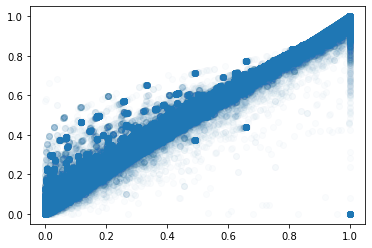

In [28]:
plt.scatter(results.pval_beta_i_on_j, results.pval_hypergeo_i_on_j, alpha=0.02)

In [34]:
rev_sig_1 = results.query('pval_hypergeo_i_on_j_BH_sig and not pval_beta_i_on_j_BH_sig')
rev_sig_2 = results.query('not pval_hypergeo_i_on_j_BH_sig and pval_beta_i_on_j_BH_sig')

In [46]:
h = results.sort_values("pval_hypergeo_i_on_j").head(1000)

,position_i,position_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_branches_with_j,n_muts_i_on_branch_j,n_muts_j_on_branch_i,n_muts_same_branch,n_branch_with_i_no_j,n_branch_with_j_no_i,n_branch_i_and_j,pval_beta_i_on_j,pval_hypergeo_i_on_j,BH_critical_value,pval_beta_i_on_j_BH_sig,pval_hypergeo_i_on_j_BH_sig
732985,2197331,2197332,123,125,628,630,1,0,121,0,2,628,0.000000e+00,0.0,0.000000,True,True
432164,1276340,1479860,78,9,5478,412,0,1,1,5066,0,412,NaN,0.0,0.000028,False,True
400626,2030521,1158722,69,5,62460,10,0,5,1,62450,0,10,NaN,0.0,0.000028,False,True
400743,2242068,1159308,10,5,294,96,0,3,1,198,0,96,NaN,0.0,0.000028,False,True
400758,2806923,1159308,8,5,262,96,0,3,1,166,0,96,NaN,0.0,0.000028,False,True
400774,3478434,1159308,10,5,296,96,0,3,1,200,0,96,NaN,0.0,0.000028,False,True
400776,3575204,1159308,8,5,262,96,0,3,1,166,0,96,NaN,0.0,0.000028,False,True
402242,2030521,1161029,69,77,62460,1456,5,77,0,61004,0,1456,NaN,0.0,0.000028,False,True
403165,2030521,1161032,69,76,62460,1456,5,76,0,61004,0,1456,NaN,0.0,0.000028,False,True
405116,1164571,1164561,343,6,14710,2,0,1,3,14708,0,2,NaN,0.0,0.000028,False,True


In [43]:
rev_sig_2.sort_values("pval_beta_i_on_j")

,position_i,position_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_branches_with_j,n_muts_i_on_branch_j,n_muts_j_on_branch_i,n_muts_same_branch,n_branch_with_i_no_j,n_branch_with_j_no_i,n_branch_i_and_j,pval_beta_i_on_j,pval_hypergeo_i_on_j,BH_critical_value,pval_beta_i_on_j_BH_sig,pval_hypergeo_i_on_j_BH_sig
18863,7582,2030521,758,69,743,62460,758,0,0,0,61717,743,6.046813e-257,0.008607,0.000680,True,False
667666,4247429,2030521,819,69,2866,62460,816,0,2,2,59596,2864,7.935311e-50,0.031810,0.001175,True,False
527681,3073679,1341044,53,8,192,53351,52,0,0,0,53159,192,3.994986e-32,0.001721,0.000366,True,False
665682,2122395,2030521,254,69,19900,62460,253,19,1,0,42560,19900,8.110978e-32,0.100249,0.002014,True,False
666729,3136335,2030521,299,69,7632,62460,298,17,1,2,54830,7630,2.593639e-30,0.123390,0.002214,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785294,2487024,3823338,19,5,632,2,1,0,0,632,2,0,2.893332e-04,0.000611,0.000263,True,False
262647,1254039,761110,16,326,10,1265,1,0,3,4,1259,6,2.893531e-04,0.000241,0.000211,True,False
473608,1532827,1339399,59,226,5290,4944,12,31,0,4340,3994,950,2.893700e-04,0.000638,0.000266,True,False
705953,2168604,2696845,7,5,646,4,1,0,0,646,4,0,2.893798e-04,0.000450,0.000245,True,False


In [59]:
h = results.sort_values("pval_hypergeo_i_on_j").head(500)
b = results.sort_values("pval_beta_i_on_j").head(500)

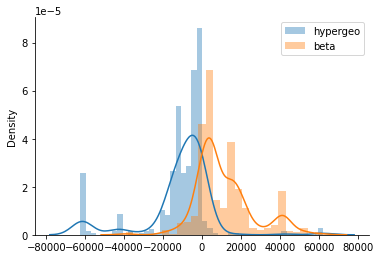

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
figure = plt.figure()
ax = figure.gca()
sns.distplot(h.n_branches_with_j - h.n_branches_with_i, label="hypergeo")
sns.distplot(b.n_branches_with_j - b.n_branches_with_i, label="beta")
sns.despine()
plt.legend()
plt.savefig("figures/beta_vs_hypergeo.pdf")

(array([  8.,  29.,  34.,  50., 252., 327., 196.,  97.,   4.,   3.]),
 array([-61717. , -51584.6, -41452.2, -31319.8, -21187.4, -11055. ,
          -922.6,   9209.8,  19342.2,  29474.6,  39607. ]),
 <BarContainer object of 10 artists>)

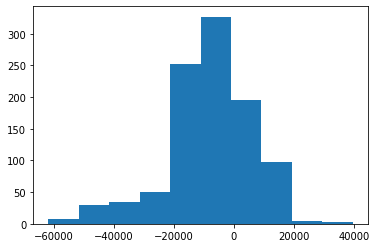

In [50]:
plt.hist(b.n_branches_with_i - b.n_branches_with_j)

In [15]:
### Beta-binomial comparison
results = pd.read_csv("02.comutation_pvalues/results_file_allpairs_betabin.csv", index_col=0)



In [16]:
print("Percent of all hits that are significant", len(results.query("pval_beta_i_on_j_BH_sig"))/len(results))
print("Total number of significant hits",len(results.query("pval_beta_i_on_j_BH_sig")))

Percent of all hits that are significant 0.02894160043226661
Total number of significant hits 53134


In [17]:
print("Percent of all hits that are significant", len(results.query("pval_betabin_i_on_j_BH_sig"))/len(results))
print("Total number of significant hits",len(results.query("pval_betabin_i_on_j_BH_sig")))

Percent of all hits that are significant 0.008223196855609008
Total number of significant hits 15097


In [18]:
# Divide into quartiles based on frequency ofmutation j
ordered = results.sort_values("n_mutations_j")

q1 = ordered.iloc[0:int(len(results)/4),:]
q2 = ordered.iloc[int(len(results)/4):2*int(len(results)/4),:]
q3 = ordered.iloc[2*int(len(results)/4):3*int(len(results)/4),:]
q4 = ordered.iloc[3*int(len(results)/4)::,:]

for i,q in enumerate([q1,q2,q3,q4]):
    print("Quartile",i)
    print(len(q))
    print("Number significant in quartile", len(q.query("pval_betabin_i_on_j_BH_sig")))
    print("Percent significant in quartile", np.round(len(q.query("pval_betabin_i_on_j_BH_sig"))/len(q),2))

Quartile 0
458976
Number significant in quartile 2830
Percent significant in quartile 0.01
Quartile 1
458976
Number significant in quartile 3181
Percent significant in quartile 0.01
Quartile 2
458976
Number significant in quartile 4135
Percent significant in quartile 0.01
Quartile 3
458976
Number significant in quartile 4951
Percent significant in quartile 0.01


In [19]:
# Divide into quartiles based on frequency ofmutation j
ordered = results.sort_values("n_mutations_i")

q1 = ordered.iloc[0:int(len(results)/4),:]
q2 = ordered.iloc[int(len(results)/4):2*int(len(results)/4),:]
q3 = ordered.iloc[2*int(len(results)/4):3*int(len(results)/4),:]
q4 = ordered.iloc[3*int(len(results)/4)::,:]

for i,q in enumerate([q1,q2,q3,q4]):
    print("Quartile",i)
    print(len(q))
    print("Number significant in quartile", len(q.query("pval_betabin_i_on_j_BH_sig")))
    print("Percent significant in quartile", np.round(len(q.query("pval_betabin_i_on_j_BH_sig"))/len(q),2))

Quartile 0
458976
Number significant in quartile 12
Percent significant in quartile 0.0
Quartile 1
458976
Number significant in quartile 5826
Percent significant in quartile 0.01
Quartile 2
458976
Number significant in quartile 5784
Percent significant in quartile 0.01
Quartile 3
458976
Number significant in quartile 3475
Percent significant in quartile 0.01


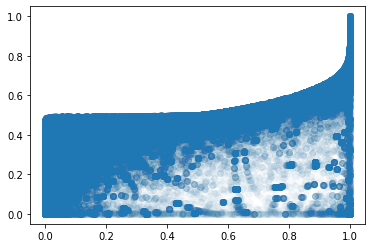

In [21]:
plt.scatter(results.pval_beta_i_on_j, results.pval_betabin_i_on_j, alpha=0.02)

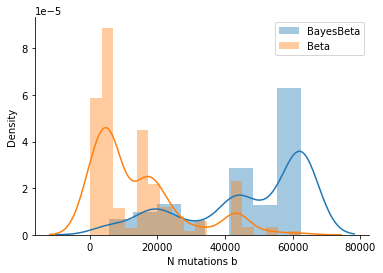

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
figure = plt.figure()
ax = figure.gca()

h = results.sort_values("pval_betabin_i_on_j").head(500)
b = results.sort_values("pval_beta_i_on_j").head(500) 
sns.distplot(h.n_branches_with_j, label="BayesBeta")
sns.distplot(b.n_branches_with_j, label="Beta")
sns.despine()
ax.set_xlabel("N mutations b")
plt.legend()
plt.savefig("figures/beta_vs_betabin.pdf")

In [24]:
h

,position_i,position_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_branches_with_j,n_muts_i_on_branch_j,n_muts_j_on_branch_i,n_muts_same_branch,n_branch_with_i_no_j,n_branch_with_j_no_i,n_branch_i_and_j,pval_beta_i_on_j,pval_betabin_i_on_j,BH_critical_value,pval_beta_i_on_j_BH_sig,pval_betabin_i_on_j_BH_sig
616780,1673425,2030521,752,69,3817,62460,744,3,1,2,58645,3815,1.000000e+00,0.000000e+00,0.000000e+00,False,True
667686,4248003,2030521,276,69,536,62460,276,0,1,0,61924,536,3.095793e-17,0.000000e+00,1.089382e-07,True,True
15402,7570,2030521,385,69,519,62460,383,0,0,4,61945,515,7.926135e-04,0.000000e+00,1.143851e-07,False,True
570127,1473246,2030521,560,69,1893,62460,560,1,1,0,60567,1893,2.572207e-138,0.000000e+00,1.198320e-07,True,True
297511,781687,1341044,783,8,5303,53351,716,1,0,88,48136,5215,7.721754e-70,0.000000e+00,1.252789e-07,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800348,4385933,2626105,40,13,606,5959,40,0,0,4,5357,602,8.697093e-90,3.021111e-49,2.696219e-06,True,True
895236,4385933,3847579,40,13,606,6011,40,0,0,0,5405,606,1.285888e-89,3.108015e-49,2.701666e-06,True,True
894762,4385933,3847578,40,13,606,6011,40,0,0,0,5405,606,1.285888e-89,3.108015e-49,2.707113e-06,True,True
895711,4385933,3847581,40,13,606,6013,40,0,0,0,5407,606,1.306921e-89,3.111688e-49,2.712560e-06,True,True
